# Machine Learning - Assignment 1
GROUP: Ângelo Gomes, up201703990 (25%); Eduardo Morgado, up201706894 (25%); 
Simão Cardoso, up201604595 (25%); Sónia Rocha, up201704679 (25%);

## Introduction
In this report we will study and evaluate several methods on their ability to approximate the Bayes Decision Boundary (BDB) on two given datasets.


In [ ]:
import itertools, statistics, warnings
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, zero_one_loss, accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
cmap = colors.ListedColormap(['blue','orange'])

In [ ]:
def dataRead(file, names=None, sep=None): 
  if names is not None:
    return pd.read_csv(file, sep=sep, names=names)
  return pd.read_csv(file)

def dataTrainTestSplit(data, target='Outcome', test_size=0.25, random_state=0, excludedFeatures=['Sequence_Name','Outcome'], distinct=False):
  if distinct:
    X = data.drop(data.columns.difference(excludedFeatures), axis=1)
    train, test = train_test_split(X, test_size=test_size, random_state=random_state,stratify=X[target])
    X_train = train[train.columns[:2]] #data used for modelling
    X_test = test[test.columns[:2]]
    y_train = train['Outcome'] # data used for predicting
    y_test = test['Outcome']
    return X_train, X_test, y_train, y_test
  else:
    X = data.drop(excludedFeatures, axis=1)
    y = data[target]
    if random_state is None:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X, y, X_train, X_test, y_train, y_test
def plotBar(data, target='Outcome'):
  ax = sns.countplot(x=target, data=data)
  ax.set_xlabel(target)
  total = len(data)
  for p in ax.patches:
      percentBMI = f'{100 * p.get_height() / total:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentBMI, (x, y), ha='center', va='center')
  plt.tight_layout()
  plt.show()

def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)

# Question 1

The following plot shows the distribution of the data between the classes. The following block of text shows the dataset description, listing all the features, all **numeric**

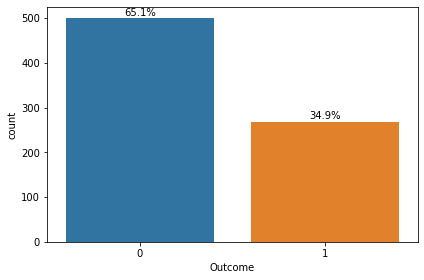

In [ ]:
file = "/content/sample_data/diabetes.csv"
data = dataRead(file)
plotBar(data)

## Choosing the correct attributes to separate the classes

In the following plot we are able to compare each feature to see which ones best separate the classes. After analysing the plot we see that **Glucose** and **BMI** are the two most adequate attribute to separate the classes

In [ ]:
sns.pairplot(data, hue = 'Outcome').fig.set_figheight(10)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe0bfb80c20> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fe0bfb0c290> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
excludedFeatures = ['Glucose','BMI','Outcome']
X_train, X_test, y_train, y_test = dataTrainTestSplit(data, excludedFeatures=excludedFeatures, target='Outcome', distinct=True)

## Analysis of KNN as an approximator to the BDB


In [ ]:
def kNNModel(X_train, y_train, X_test, y_test, max_k=30):
  max_iterations = max_k + 1
  neighbors = np.arange(1,max_iterations)
  acuraccy_train_list, accuracy_test_list = np.empty(max_iterations), np.empty(max_iterations)
  best_accuracy = [0,0]
  for k in range(1,max_iterations):
    model = kNN(n_neighbors=k).fit(X_train, y_train)
    acuraccy_train_list[k] = model.score(X_train,y_train)
    accuracy_test_list[k] = model.score(X_test, y_test)  
    if best_accuracy[1] < accuracy_test_list[k]:
      best_accuracy[0], best_accuracy[1] = [k, accuracy_test_list[k]]
  acuraccy_train_list, accuracy_test_list = acuraccy_train_list[1:], accuracy_test_list[1:]
  return acuraccy_train_list, accuracy_test_list, best_accuracy, neighbors

def plotKnn(neighbors, accuracy_train_list, accuracy_test_list): #Generate plot
  plt.title('k-NN Varying number of neighbors')
  plt.plot(neighbors, accuracy_test_list, label='Testing Accuracy')
  plt.plot(neighbors, accuracy_train_list, label='Training accuracy')
  plt.legend()
  plt.xlabel('Number of neighbors')
  plt.ylabel('Accuracy')
  plt.show()

def knn(X_train, y_train, X_test, y_test, max_k=30):
  acuraccy_train_list, accuracy_test_list, best_accuracy, neighbors = kNNModel(X_train, y_train, X_test, y_test, max_k=max_k)
  print('Best accuracy:\t', best_accuracy) 
  plotKnn(neighbors,acuraccy_train_list,accuracy_test_list)
  return best_accuracy


def plot_classifier_boundary(model,X,y,h = .5):
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = X['Glucose'].min()-.2, X['Glucose'].max()+.2
    y_min, y_max = X['BMI'].min()-.2, X['BMI'].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))

The following graph shows the accuracy of our KNN model with increasing values of k. By looking at the graph, as well as the output of our method we react an accuracy peak of value **79,7%** with a value of k of **23**.

By increasing the k we notice that the training accuracy of our model decreases and the model stops overfitting until we reach a peak and the testing accuracy starts decreasing which may indicate that the model is undefitting.

Best accuracy:	 [23, 0.796875]


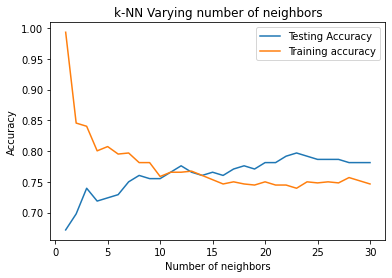

In [ ]:
best_accuracy = knn(X_train, y_train, X_test, y_test)

The following plot shows the KNN decision boundary for our two selected attributes when k is our best value (23)

Text(0, 0.5, 'BMI')

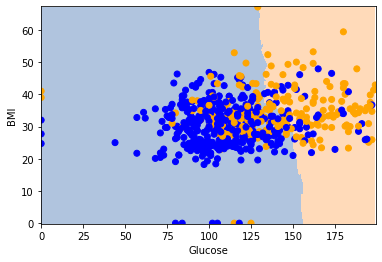

In [ ]:
modelknn = kNN(n_neighbors=best_accuracy[0])
modelknn.fit(X_train, y_train)
plot_classifier_boundary(modelknn,X_train,y_train)
cmap = colors.ListedColormap(['blue','orange'])
plt.scatter(X_train['Glucose'],X_train['BMI'],color=cmap(y_train))
plt.xlabel('Glucose')
plt.ylabel('BMI')

The boundary given by kNN is more detailed then the other methods we are going to see. It has less assumptions. This method has a lower bias and a high variance especially with a small k value.

## Analysis of Logistic Regression as an approximator to the BDB

In [ ]:
def logisticRegressionBinary(train_X, train_y, test_X, test_y):
  def calc(model):
    b = model.intercept_[0] # Retrieve the model parameters.
    w1, w2 = model.coef_.T
    c, m = -b/w2, -w1/w2 # Calculate the intercept and gradient of the decision boundary.
    xmin, xmax = min(train_X["Glucose"])-.2, max(train_X["Glucose"])+.2 # prepare the points for drawing the linear boundary
    xbound = np.array([xmin, xmax])
    ybound = m*xbound + c
    return xbound, ybound
  def plot(xbound, ybound): # replot, but now with the boundary
    plt.scatter(train_X["Glucose"],train_X["BMI"],color=cmap(train_y))
    plt.xlabel('Glucose')
    plt.ylabel('BMI')
    plt.plot(xbound,ybound,color='red')
    
  model = LogisticRegression(random_state=0).fit(train_X, train_y)
  print('Train accuracy:\t', model.score(train_X,train_y))
  print('Test accuracy:\t', model.score(test_X,test_y))
  xbound, ybound = calc(model)
  plot(xbound, ybound)
  return model

The following plot shows the accuracy for our logistic regression model (without folds). Overall this has the same training accuracy as our KNN model and the testing accuracy if very close to the KNN's

Train accuracy:	 0.7604166666666666
Test accuracy:	 0.78125


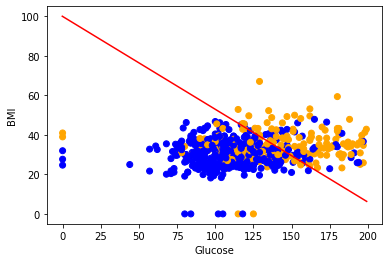

In [ ]:
modelLR = logisticRegressionBinary(X_train, y_train, X_test, y_test)

o logistic regression give a flat boundary with a high bias and low variance

## Analysis of Quadratic Discriminant Analysis as an approximator to the BDB

In [ ]:
def quadraticBinary(train_X, train_y,test_X,test_y):
  def plot_classifier_boundary(model,X,h = .05): # this function can be used with any sklearn classifier ready for two classes but can be easily extended
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = X['Glucose'].min()-.2, X['Glucose'].max()+.2
    y_min, y_max = X['BMI'].min()-.2, X['BMI'].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # generate a grid with step h
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))

  #kf = KFold(shuffle=True, n_splits=5)
  #cv_results = cross_val_score(logreg, X, y, cv=kf, scoring='accuracy')

  model = QDA().fit(train_X,train_y)
  print('Train accuracy:\t', model.score(train_X,train_y))
  print('Test accuracy:\t', model.score(test_X,test_y))
  plot_classifier_boundary(model,train_X)
  plt.scatter(train_X['Glucose'],train_X['BMI'],color=cmap(train_y))
  plt.title('QDA')
  plt.xlabel('Glucose')
  plt.ylabel('BMI');
  return model

Train accuracy:	 0.7534722222222222
Test accuracy:	 0.7864583333333334


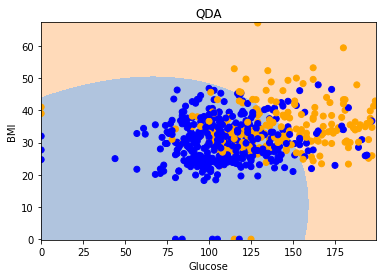

In [ ]:
modelquad = quadraticBinary(X_train, y_train, X_test, y_test)

QDA has a quadratic decision boundary , can modulate with less bias then the other methods like logistic.
But it is less flexible then kNN, it makes some assumptions of the decision boundary form.

## Comparison of the methods in the approximation of BDB


In [ ]:
#KNN prediction
print('KNN classification')
y_pred = modelknn.predict(X_test)
print(classification_report(y_test, y_pred))
print('****CONFUSION MATRIX****\n',confusion_matrix(y_test, y_pred))
print('\nAccuracy is: ',accuracy_score(y_pred,y_test),'\n\n')
#Logistic Regression prediction
print('Logistic Regression classification')
y_pred = modelLR.predict(X_test)
print(classification_report(y_test, y_pred))
print('****CONFUSION MATRIX****\n',confusion_matrix(y_test, y_pred))
print('\nAccuracy is: ',accuracy_score(y_pred,y_test),'\n\n')
#Quadratic Discriminant Analysis prediction:
print('Quadratic Discriminant Analysis classification')
y_pred = modelquad.predict(X_test)
print(classification_report(y_test,y_pred))
print('****CONFUSION MATRIX****\n',confusion_matrix(y_pred,y_test))
print('\naccuracy is: ',accuracy_score(y_pred,y_test)) 

KNN classification
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       125
           1       0.75      0.63      0.68        67

    accuracy                           0.80       192
   macro avg       0.78      0.76      0.77       192
weighted avg       0.79      0.80      0.79       192

****CONFUSION MATRIX****
 [[111  14]
 [ 25  42]]

Accuracy is:  0.796875 


Logistic Regression classification
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       125
           1       0.74      0.58      0.65        67

    accuracy                           0.78       192
   macro avg       0.77      0.74      0.75       192
weighted avg       0.78      0.78      0.77       192

****CONFUSION MATRIX****
 [[111  14]
 [ 28  39]]

Accuracy is:  0.78125 


Quadratic Discriminant Analysis classification
              precision    recall  f1-score   support

           0       0.80      0.90      

# Question 2
Here we will analyse the Yeast UCI dataset and generate models to approximate the BDB

The following plot shows the distribution of the data for each class in the target attribute and the next text block shows the dataset description, this dataset again only has **numeric data**

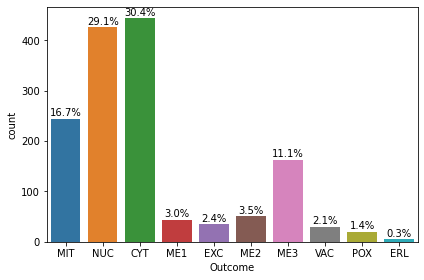

In [ ]:
file = "/content/sample_data/yeast.data"
names = ["Sequence_Name","mcg","gvh","alm","mit","erl","pox","vac","nuc","Outcome"]
sep='\s+'
data2 = dataRead(file, names=names, sep=sep)
data2 = data2.drop_duplicates(subset = ['Sequence_Name'], keep='last') #Remove duplicates (Sequence_Name)
plotBar(data2)

## Analysis of KNN

Best accuracy:	 [19, 0.6147540983606558]


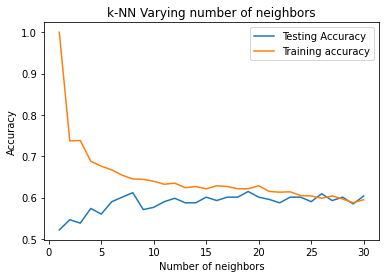

In [ ]:
_, _, X_train, X_test, y_train, y_test = dataTrainTestSplit(data2, target='Outcome')
best_accuracy = knn(X_train, y_train, X_test, y_test)

## Analysis of Logistic Regression with Stratified Kfolding

In [ ]:
def logisticRegressionModel(X, y, n_splits=5, max_iterations=1000):
  skf = StratifiedKFold(n_splits=n_splits)
  acuraccy_train_list = []
  accuracy_test_list = []
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      model= LogisticRegression(max_iter=max_iterations).fit(np.array(X_train), y_train)
      y_pred = model.predict(X_test)
      #fold_loss = zero_one_loss(y_test, y_pred)
      acuraccy_train =  model.score(X_train,y_train)
      acuraccy_test =  model.score(X_test,y_test)
      acuraccy_train_list.append(acuraccy_train)
      accuracy_test_list.append(acuraccy_test)
  return statistics.mean(acuraccy_train_list), statistics.mean(accuracy_test_list)

def plotLogisticRegression(splits, accuracy_train_list, accuracy_test_list, max_iterations):
  #Generate plot
  plt.title('Logistic regression with varying number of splits and max_iterations ' + str(max_iterations))
  plt.plot(splits, accuracy_test_list, label='Testing Accuracy')
  plt.plot(splits, accuracy_train_list, label='Training accuracy')
  plt.legend()
  plt.xlabel('Splits')
  plt.ylabel('Accuracy')
  plt.show()


def logisticRegression(X, y, start_split=2, max_split_iterations=5, max_iterations=1000):
  split = start_split
  splits = []
  accuracy_train_list = []
  accuracy_test_list = []
  for _ in range(1,max_split_iterations - 1):
    accuracy_train, accuracy_test = logisticRegressionModel(X, y, n_splits=split, max_iterations=max_iterations)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    splits.append(split)
    split += 1
  plotLogisticRegression(splits, accuracy_train_list, accuracy_test_list, max_iterations)

The following graph shows the prediction performance of our model with varying number of bin sizes in our KFold. 

Although there are prediction improvements with number of slipts bigger than 5 since one of our target classes only has 5 training elements it doesn’t make much sense to consider splits bigger than that. This is because by increasing the number of splits we are in fact decreasing the presence of that class in our model thus decreasing the prediction ability for that class (ERL), not only that but we are also increasing the predicion ability for the other classes since they have more than 5 elements and thus can be on bigger folds.

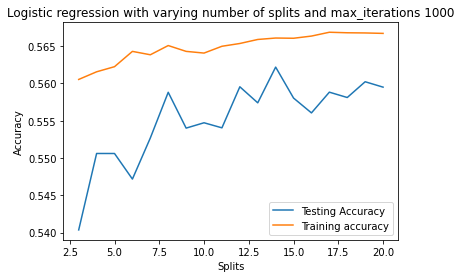

In [ ]:
X, y, _, _, _, _ = dataTrainTestSplit(data2, target='Outcome')
logisticRegression(X, y, start_split=3, max_split_iterations=20)

After considering a fold with 5 splits the accuracy of our model is ruffly 55%

In [ ]:
accuracy_train, accuracy_test = logisticRegressionModel(X, y, n_splits=5) #a menor classe so tem 5 elementos 
accuracy_test

0.5505984384496704

## Analysis of Decison Tree

In [ ]:
def decisionTreeModel(X_train, X_test, y_train, y_test, max_depth=5, criterion="gini"):
  model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth).fit(X_train, y_train)
  accuracy_train = model.score(X_train, y_train)
  accuracy_test = model.score(X_test, y_test)
  return accuracy_train, accuracy_test

def plotDecisionTree(depths, accuracy_train_list, accuracy_test_list, criterion): #Generate plot
  plt.title('Decison Tree with varying number of depths, criterion: ' + str(criterion))
  plt.plot(depths, accuracy_test_list, label='Testing Accuracy')
  plt.plot(depths, accuracy_train_list, label='Training accuracy')
  plt.legend()
  plt.xlabel('Depth')
  plt.ylabel('Accuracy')
  plt.show()

def decisionTree(X_train, X_test, y_train, y_test, start_depth=2, max_iterations=20, criterion="gini"):  #Default criteria Gini
  depth = start_depth
  depths = []
  accuracy_train_list = []
  accuracy_test_list = []
  for _ in range(1,max_iterations):
    accuracy_train, accuracy_test = decisionTreeModel(X_train, X_test, y_train, y_test, max_depth=depth, criterion=criterion)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    depths.append(depth)
    depth += 1
  plotDecisionTree(depths, accuracy_train_list, accuracy_test_list, criterion)

The following graph shows the evolution of our decision tree model as we increase its maximum depth. This decison tree uses the CART model and uses the **gini index** as a classification criterion.

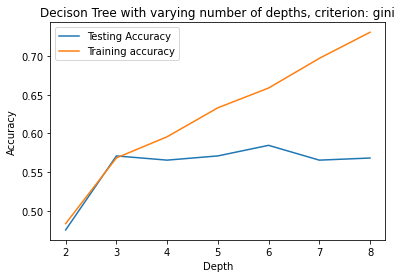

In [ ]:
_, _, X_train, X_test, y_train, y_test = dataTrainTestSplit(data2, target='Outcome', random_state=0)
decisionTree(X_train, X_test, y_train, y_test, max_iterations=8, start_depth=2)

By looking at the graph we notice that after a certain number of max depth the model starts to overfit (on max depth 8 the training accuracy is almost 100%) as such we will consider the best model for the Gini index decision tree to be of depth 3 (with accuracy of 57%), the point where our testing accuracy crosses our traing accuracy.

In [ ]:
accuracy_Tree_train, accuracy_Tree_test = decisionTreeModel(X_train, X_test, y_train, y_test, max_depth=3)
accuracy_Tree_test

0.5710382513661202

We also decided to see the performance of the decision tree when our criterion is the information gain, entropty.

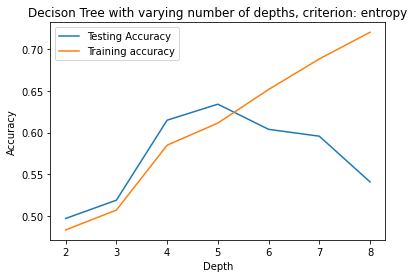

In [ ]:
decisionTree(X_train, X_test, y_train, y_test, max_iterations=8, start_depth=2, criterion='entropy')

Once again we see a point where our model starts to overfit when we consider a max depth bigger than 5. As such, we chose the best model for the entropy decision tree to be of depth 3 with an accuracy of 63%

In [ ]:
accuracy_Tree_train, accuracy_Tree_test = decisionTreeModel(X_train, X_test, y_train, y_test, max_depth=5, criterion='entropy')
accuracy_Tree_test

0.6311475409836066

# Conclusion


By looking at the classification reports in the first question we notice that using the KNN model the results for both testing and training accuracy are more satisfactory than for the other two methods, we decided to use the accuracy as an evaluation metric since all this methods had very similar precison/recall and f1-score and the confusion matrix was also similar. 

One thing that we noticed was that, although its accuracy is lesser than the KNN's, when compared to it the quadratic discriminat analysis predicts the class 1 more often than KNN which may be useful in some cases.


On the second question, we noticed that the logistic regression method had the least value of accuracy which may have something to do with our dataset and the fact that our classes are highly correlated or nonlinear which would mean that the coefficients for our logist regression won't be able to predict the gain/loss for each variable as easily.

When comparing the decision tree criterions, the best criterion would be using the entropy since this method would consider how much information do we get when we see an element of some variable.

We found it odd that the accuracy of the KNN and the DT are so close, this might be related to the fact the KNN is a clustering method that uses distance metrics to generate the models as well as the fact the it is a lazy learner, learning as new data is commin in which means that with a big enough dataset it would be able to model very complex data relations which would explain the results, that and the fact that in sklearn the decision tree that is used is the CART decision tree which is not very efficient with continuous data where it would be recommended a C4.5 tree.

For the second question we chose the decision tree both because it was the one that gave the best accuracy but also the one that got generated the fastest, as we mentioned KNN is able to model almost any numeric data but since it's a lazy learner it would take linearly more time to train as the dataset increases.


